<a href="https://colab.research.google.com/github/CastanharoA/_projetos/blob/master/TGII_AMFC_PARTE1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TGII AMFC

Estudo de caso de utilização de derivadas em série temporal com a finalidade de prever e analisar a flutuação no mercado financeiro de renda variável analisando ativos comercializados na Bolsa de Valores de São Paulo (B3)

https://www.loom.com/share/5f4315ab12c1453c973e704d6bb4a0b0?sid=7c5fe8a7-894d-436b-8e31-d1c3f6dd241c (link loom)

Versão 05/2024





##0 Parte: Import e massa de dados

###Imports

In [ ]:
!pip install ruptures #pontos de mudança


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.9 MB/s eta 0:00:00


In [ ]:
# Imports Comuns
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf #yahoo finance
import numpy as np
from scipy.stats import f
import seaborn as sns
import matplotlib.pyplot as plt
#ciclicidade
from itertools import groupby
#teste
import unittest
#carta controle
import ruptures as rpt
from sklearn.model_selection import TimeSeriesSplit
#heatmap
import seaborn as sns

###Download

[*********************100%%**********************]  1 of 1 completed


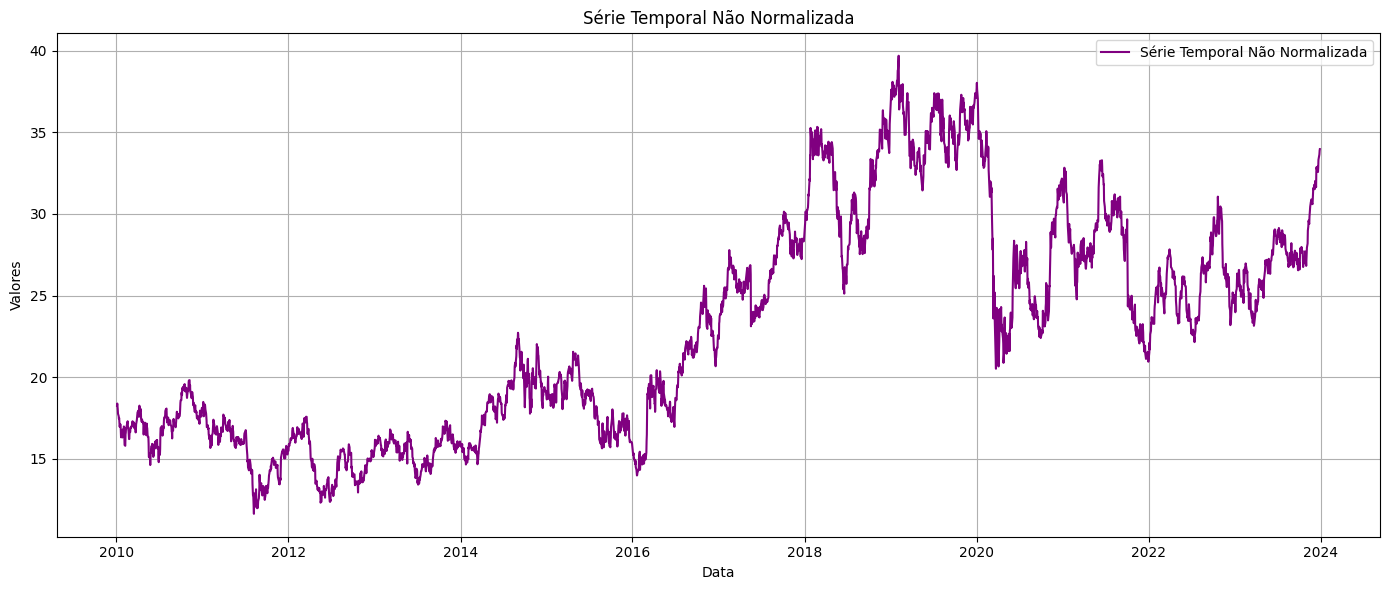

In [ ]:
# Download dos Dados (Fase 2: Compreensão dos Dados)
def download_stock_data(ticker, start_date, end_date):
    """Baixar dados de ações do Yahoo Finance."""
    dados = yf.download(ticker, start_date, end_date)
    return dados
dados = download_stock_data('ITUB4.SA', '2010-01-01', '2024-01-01')

# Plotar a série temporal não normalizada
plt.figure(figsize=(14, 6))
plt.plot(dados['Close'], label='Série Temporal Não Normalizada', color='purple')
plt.title('Série Temporal Não Normalizada')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
print(dados.head(2)) #n normalizados
dados.describe()
dados.info()
dados_type = dados.dtypes
print(dados_type)

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2010-01-04  17.708261  18.436810  17.708261  18.268333  10.141710  11843397
2010-01-05  18.313868  18.386723  18.168158  18.386723  10.207425   8593315
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3473 entries, 2010-01-04 to 2023-12-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3473 non-null   float64
 1   High       3473 non-null   float64
 2   Low        3473 non-null   float64
 3   Close      3473 non-null   float64
 4   Adj Close  3473 non-null   float64
 5   Volume     3473 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 189.9 KB
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


##1 Parte: Derivadas e Descritores de Hjorth

#### Separaçao de derivada e descritores

In [ ]:
nao rodar # exemplo def hjorth_activity(dados): #
    """Calcular os descritores de Hjorth."""
    # Passo 1: Calcular a primeira derivada (velocidade de mudança)
    diff = np.diff(dados)
    '''Calcula a diferença entre os elementos adjacentes na série temporal,
    efetivamente calculando a primeira derivada com h=1'''
    # Passo 2: Calcular a segunda derivada (aceleração de mudança)
    diff_diff = np.diff(diff)
    '''Calcula a diferença entre os elementos adjacentes na série temporalresultante da primeira derivada,
    efetivamente calculando a segunda derivada com h=1.'''
    # Passo 3: Calcular as variâncias das derivadas
    var_activity = np.var(dados)
    '''Calcula a variância da série temporal original, que é uma medida da dispersão dos valores em torno da média.'''
    var_diff = np.var(diff)
    '''Calcula a variância da primeira derivada, que mede a variabilidade na velocidade de mudança'''
    var_diff_diff = np.var(diff_diff)
    '''Calcula a variância da segunda derivada, que mede a variabilidade na aceleração de mudança'''
    # Passo 4: Calcular os descritores de Hjorth
    activity = np.sqrt(var_activity)
    '''A atividade é a raiz quadrada da variância da série temporal original,
    uma medida da intensidade da série temporal'''
    mobility = np.sqrt(var_diff / var_activity) if var_activity!= 0 else np.nan
    ''' A mobilidade é a raiz quadrada da razão entre a variância da primeira derivada e
    a variância da série temporal original,
    medindo a rapidez com que a série temporal muda''''
    complexity = np.sqrt(var_diff_diff / var_diff) if var_diff!= 0 else np.nan
    '''  A complexidade é a raiz quadrada da razão entre a variância da segunda derivada e a
    variância da primeira derivada, medindo a complexidade ou diversidade na série temporal'''

    # Impede a divisão por 0, evita o NAN / erro
    return activity, mobility, complexity


### *Hjorth Função das derivadas + indicadores e normalização

In [ ]:
# Seção 1: Derivadas e Descritores de Hjorth
# Função de cálculo  (Fase 4: Modelagem)

def hjorth_activity(dados):
    """Calcular os descritores de Hjorth."""
    diff = np.diff(dados)  #primeira derivada
    diff_diff = np.diff(diff)# segunda derivada

    var_activity = np.var(dados) #primeira derivada
    var_diff = np.var(diff) # segunda derivada
    var_diff_diff = np.var(diff_diff)

    activity = np.sqrt(var_activity)
    mobility = np.sqrt(var_diff / var_activity) if var_activity != 0 else np.nan
    complexity = np.sqrt(var_diff_diff / var_diff) if var_diff != 0 else np.nan
    #Impede a divisão por 0, evita o NAN /erro
    return activity, mobility, complexity

# Função de cálculo novas colunas serão indicadores (Fase 4: Modelagem)
def calculate_indicators(dados):
    """Calcular a mediana de 20 dias e os descritores de Hjorth."""
    dados['20_day_median'] = dados['Close'].rolling(window=20).median()

    activity = []
    mobility = []
    complexity = []

    for i in range(20, len(dados['Close'])):
        window_data = dados['Close'].values[i-20:i]
        if not np.isnan(window_data).any():  # Verifica janela não contém NaN
            act, mob, com = hjorth_activity(window_data)
        else:
            act, mob, com = np.nan, np.nan, np.nan
        activity.append(act)
        mobility.append(mob)
        complexity.append(com)

    # Adicionando NaNs para alinhar o tamanho das listas com o DataFrame original
    dados['activity'] = [np.nan] * 20 + activity
    dados['mobility'] = [np.nan] * 20 + mobility
    dados['complexity'] = [np.nan] * 20 + complexity
    return dados

# Passo 2: Calcular indicadores
dados = calculate_indicators(dados)
print(dados[['20_day_median', 'activity', 'mobility', 'complexity', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].dropna())


# Função de normalização dos dados (Fase 2: Compreensão dos Dados)
def normalize_data(dados):
    """Normalizar os dados das ações."""
    dados_normalized = (dados - dados.min()) / (dados.max() - dados.min())
    return dados_normalized

# Passo 3: Normalizar dados
dados_normalized = normalize_data(dados)

# Verificar e limpar dados normalizados
dados_normalized = dados_normalized.fillna(0)
dados_normalized = dados_normalized.replace([np.inf, -np.inf], np.nan).fillna(0)

print("\nVerificação de valores de nan:")
print(dados_normalized.isna().sum())
print(np.isinf(dados_normalized).sum())




            20_day_median  activity  mobility  complexity       Open  \
Date                                                                   
2010-02-02      17.029801  0.661687  0.362458    1.597687  16.979713   
2010-02-03      16.977437  0.615614  0.398711    1.538579  17.007034   
2010-02-04      16.941010  0.545739  0.448243    1.571876  16.711061   
2010-02-05      16.854495  0.502413  0.549931    1.472929  16.087242   
2010-02-08      16.779364  0.494847  0.571569    1.449951  15.886892   
...                   ...       ...       ...         ...        ...   
2023-12-21      31.719999  0.739223  0.416316    1.468008  32.750000   
2023-12-22      31.799999  0.737186  0.410551    1.552894  32.820000   
2023-12-26      31.910000  0.745214  0.418969    1.495408  33.369999   
2023-12-27      32.295000  0.751988  0.416773    1.494683  33.610001   
2023-12-28      32.584999  0.780667  0.401784    1.481466  33.880001   

                 High        Low      Close  Adj Close    Volum

###Variáveis

In [ ]:
print(dados[['20_day_median', 'activity', 'mobility', 'complexity', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].dropna())


            20_day_median  activity  mobility  complexity       Open  \
Date                                                                   
2010-02-02      17.029801  0.661687  0.362458    1.597687  16.979713   
2010-02-03      16.977437  0.615614  0.398711    1.538579  17.007034   
2010-02-04      16.941010  0.545739  0.448243    1.571876  16.711061   
2010-02-05      16.854495  0.502413  0.549931    1.472929  16.087242   
2010-02-08      16.779364  0.494847  0.571569    1.449951  15.886892   
...                   ...       ...       ...         ...        ...   
2023-12-21      31.719999  0.739223  0.416316    1.468008  32.750000   
2023-12-22      31.799999  0.737186  0.410551    1.552894  32.820000   
2023-12-26      31.910000  0.745214  0.418969    1.495408  33.369999   
2023-12-27      32.295000  0.751988  0.416773    1.494683  33.610001   
2023-12-28      32.584999  0.780667  0.401784    1.481466  33.880001   

                 High        Low      Close  Adj Close    Volum

In [ ]:
dados_all = dados[['20_day_median', 'activity', 'mobility', 'complexity', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].dropna()
print(dados_all.head(3))

            20_day_median  activity  mobility  complexity       Open  \
Date                                                                   
2010-02-02      17.029801  0.661687  0.362458    1.597687  16.979713   
2010-02-03      16.977437  0.615614  0.398711    1.538579  17.007034   
2010-02-04      16.941010  0.545739  0.448243    1.571876  16.711061   

                 High        Low      Close  Adj Close    Volume  
Date                                                              
2010-02-02  17.152744  16.765703  16.984266   9.428853  10004341  
2010-02-03  17.111763  16.715614  16.911413   9.388404   7783594  
2010-02-04  16.802132  16.069029  16.260273   9.026921  11598966  


In [ ]:
print(dados_normalized.head(1))
dados_all_normalized = dados_normalized.copy()
print(dados_all_normalized.head(1))

                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2010-01-04  0.217424  0.229778  0.232165  0.236468    0.13537  0.073713   

            20_day_median  activity  mobility  complexity  
Date                                                       
2010-01-04            0.0       0.0       0.0         0.0  
                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2010-01-04  0.217424  0.229778  0.232165  0.236468    0.13537  0.073713   

            20_day_median  activity  mobility  complexity  
Date                                                       
2010-01-04            0.0       0.0       0.0         0.0  


In [ ]:
dados = dados[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].dropna()
print(dados.head(1))

                 Open      High        Low      Close  Adj Close    Volume
Date                                                                      
2010-01-04  17.708261  18.43681  17.708261  18.268333   10.14171  11843397


In [ ]:
dados_normalized_o = dados_normalized[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].dropna()
print(dados_normalized_o.head(1))

                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2010-01-04  0.217424  0.229778  0.232165  0.236468    0.13537  0.073713


### *Plot Hjorth de dados normalizados

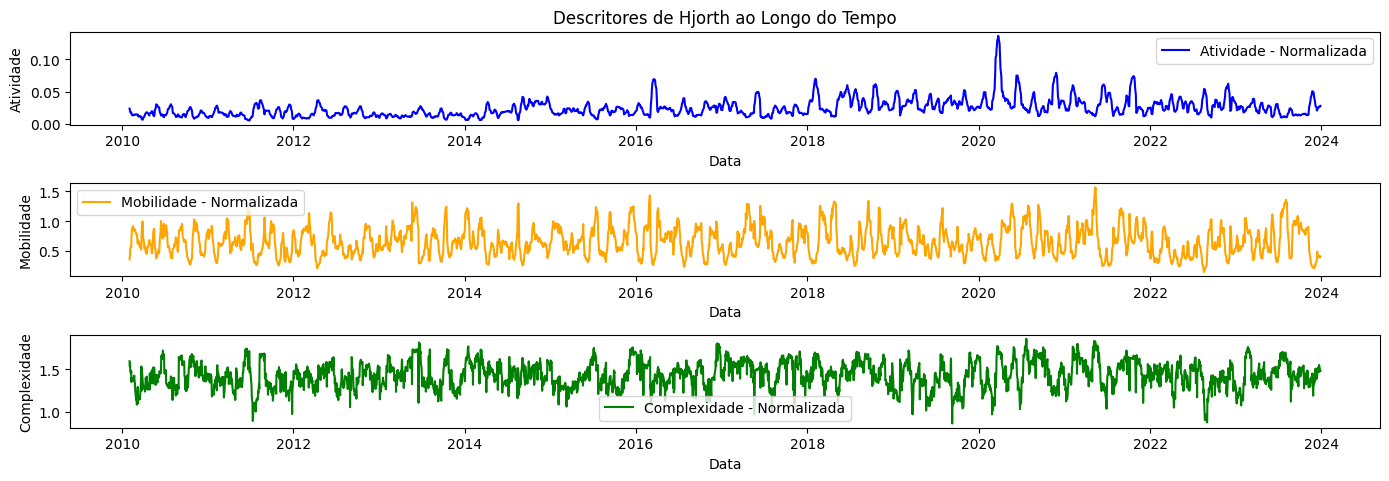

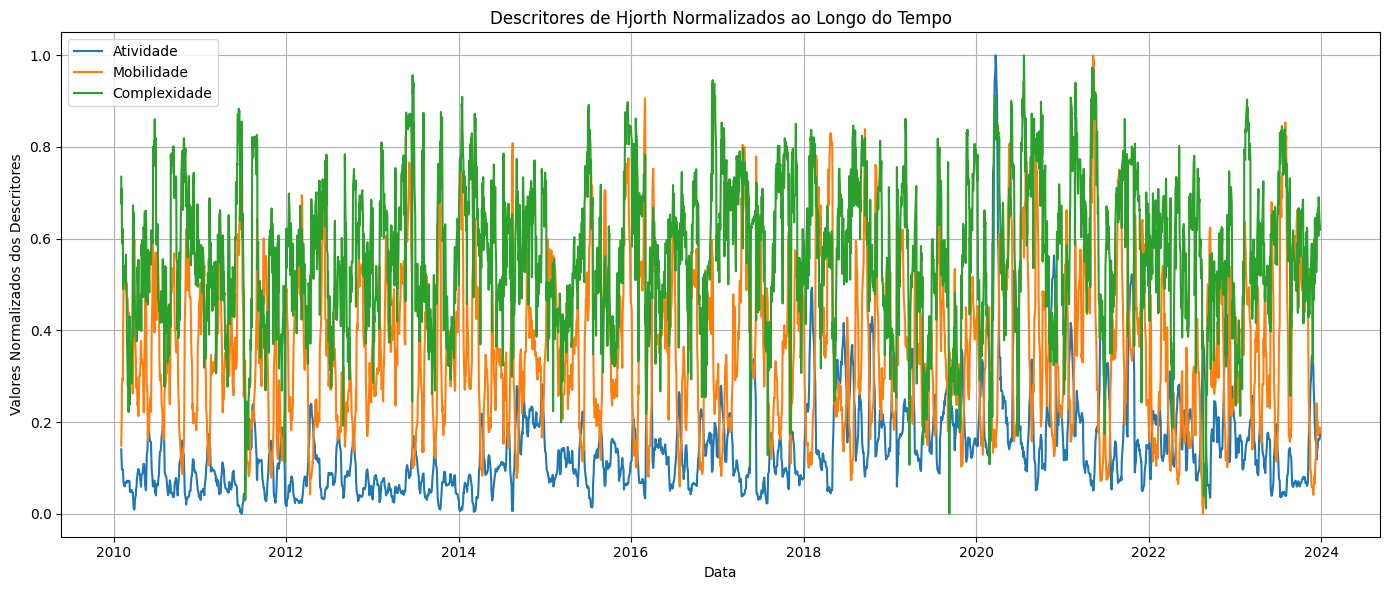

In [ ]:
# Seção hojort. plot

# Função de plot encontrar ciclos nos descritores de Hjorth (Fase 4: Modelagem)
def find_cycles(dados_normalized):
    """Encontrar ciclos nos descritores de Hjorth."""
    activity = []
    mobility = []
    complexity = []

    for i in range(20, len(dados_normalized)):
        window_data = dados_normalized['Close'].values[i-20:i]
        if not np.isnan(window_data).any():  # Verifica se a janela de dados não contém NaN
            act, mob, com = hjorth_activity(window_data)
        else:
            act, mob, com = np.nan, np.nan, np.nan
        activity.append(act)
        mobility.append(mob)
        complexity.append(com)

    plt.figure(figsize=(14, 6))
    plt.subplot(4, 1, 1)
    plt.plot(dados_normalized.index[20:], activity, label='Atividade - Normalizada', color='blue')
    plt.title("Descritores de Hjorth ao Longo do Tempo")
    plt.xlabel('Data')
    plt.ylabel('Atividade')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(dados_normalized.index[20:], mobility, label='Mobilidade - Normalizada', color='orange')
    plt.xlabel('Data')
    plt.ylabel('Mobilidade')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(dados_normalized.index[20:], complexity, label='Complexidade - Normalizada', color='green')
    plt.xlabel('Data')
    plt.ylabel('Complexidade')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Passo: Encontrar ciclos nos descritores de Hjorth
find_cycles(dados_normalized)

# Função de plotar os descritores de Hjorth (Fase 4: Modelagem)
def plot_hjorth_descriptors(dados_normalized):
    """Plotar os descritores de Hjorth ao longo do tempo."""
    hjorth_data = []

    for i in range(20, len(dados_normalized)):
        window_data = dados_normalized['Close'].values[i-20:i]
        if not np.isnan(window_data).any():  # Verifica não contém NaN
            activity, mobility, complexity = hjorth_activity(window_data)
        else:
            activity, mobility, complexity = np.nan, np.nan, np.nan
        hjorth_data.append((activity, mobility, complexity))

    hjorth_df = pd.DataFrame(hjorth_data, columns=['activity' , 'mobility'  ,'complexity'], index=dados_normalized.index[20:])

    # Normalizar os descritores de Hjorth
    hjorth_df_normalized = (hjorth_df - hjorth_df.min()) / (hjorth_df.max() - hjorth_df.min())

    # Plotar os descritores de Hjorth normalizados em um único gráfico
    fig, ax = plt.subplots(figsize=(14, 6))
#activity  mobility  complexity
    ax.plot(hjorth_df_normalized.index, hjorth_df_normalized['activity'], label='Atividade')
    ax.plot(hjorth_df_normalized.index, hjorth_df_normalized['mobility'], label='Mobilidade')
    ax.plot(hjorth_df_normalized.index, hjorth_df_normalized['complexity'], label='Complexidade')

    plt.title("Descritores de Hjorth Normalizados ao Longo do Tempo")
    plt.xlabel('Data')
    plt.ylabel('Valores Normalizados dos Descritores')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Passo: Plotar descritores de Hjorth separadamente
plot_hjorth_descriptors(dados_normalized)




In [ ]:
print(dados_normalized.head(3))

                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2010-01-04  0.217424  0.229778  0.232165  0.236468   0.135370  0.073713   
2010-01-05  0.240034  0.227971  0.249231  0.240687   0.137903  0.053484   
2010-01-06  0.240543  0.229778  0.245851  0.235007   0.134493  0.065990   

            20_day_median  activity  mobility  complexity  
Date                                                       
2010-01-04            0.0       0.0       0.0         0.0  
2010-01-05            0.0       0.0       0.0         0.0  
2010-01-06            0.0       0.0       0.0         0.0  


In [ ]:
# Imprimindo os resultados dos descritores de Hjorth ao longo do tempo
print("\nDescritores de Hjorth ao Longo do Tempo:")
for i in range(20, len(dados_normalized)):
    data = dados_normalized.index[i]
    activity, mobility, complexity = hjorth_activity(dados_normalized['Close'].values[i-20:i])
    print(f"{data}: Atividade={activity:.4f}, Mobilidade={mobility:.4f}, Complexidade={complexity:.4f}")


Descritores de Hjorth ao Longo do Tempo:
2010-02-02 00:00:00: Atividade=0.0236, Mobilidade=0.3625, Complexidade=1.5977
2010-02-03 00:00:00: Atividade=0.0219, Mobilidade=0.3987, Complexidade=1.5386
2010-02-04 00:00:00: Atividade=0.0195, Mobilidade=0.4482, Complexidade=1.5719
2010-02-05 00:00:00: Atividade=0.0179, Mobilidade=0.5499, Complexidade=1.4729
2010-02-08 00:00:00: Atividade=0.0176, Mobilidade=0.5716, Complexidade=1.4500
2010-02-09 00:00:00: Atividade=0.0178, Mobilidade=0.5667, Complexidade=1.4830
2010-02-10 00:00:00: Atividade=0.0164, Mobilidade=0.7244, Complexidade=1.3510
2010-02-11 00:00:00: Atividade=0.0152, Mobilidade=0.7818, Complexidade=1.4037
2010-02-12 00:00:00: Atividade=0.0138, Mobilidade=0.8791, Complexidade=1.3878
2010-02-17 00:00:00: Atividade=0.0129, Mobilidade=0.9180, Complexidade=1.3972
2010-02-18 00:00:00: Atividade=0.0136, Mobilidade=0.8960, Complexidade=1.3778
2010-02-19 00:00:00: Atividade=0.0141, Mobilidade=0.8647, Complexidade=1.3654
2010-02-22 00:00:00: A

### *Metricas Hjorth

In [ ]:
print(dados.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [ ]:
print(dados_normalized.head(1))

                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2010-01-04  0.217424  0.229778  0.232165  0.236468    0.13537  0.073713   

            20_day_median  activity  mobility  complexity  
Date                                                       
2010-01-04            0.0       0.0       0.0         0.0  


In [ ]:
#dados_normalized. Close

# Função para calcular volatilidade
def calculate_volatility(activity_series):
    if len(activity_series) == 0 or np.isnan(activity_series).all():
        return np.nan, np.nan, np.nan, np.nan, np.nan
    volatility_historical = np.nanstd(activity_series)
    volatility_normalized = (volatility_historical - np.nanmin(activity_series)) / (np.nanmax(activity_series) - np.nanmin(activity_series))
    volatility_annualized = volatility_historical * np.sqrt(252)
    activity_mean = np.nanmean(activity_series)
    activity_max = np.nanmax(activity_series)
    return volatility_historical, volatility_normalized, volatility_annualized, activity_mean, activity_max


def calculate_mobility(mobility_series):
    if len(mobility_series) == 0 or np.isnan(mobility_series).all():
        return np.nan, np.nan, np.nan, np.nan, np.nan
    mobility_mean = np.nanmean(mobility_series)
    mobility_normalized = (mobility_mean - np.nanmin(mobility_series)) / (np.nanmax(mobility_series) - np.nanmin(mobility_series))
    mobility_annualized = mobility_mean * np.sqrt(252)
    mobility_max = np.nanmax(mobility_series)
    mobility_min = np.nanmin(mobility_series)
    return mobility_mean, mobility_normalized, mobility_annualized, mobility_max, mobility_min


def calculate_complexity(complexity_series):
    if len(complexity_series) == 0 or np.isnan(complexity_series).all():
        return np.nan, np.nan
    complexity_mean = np.nanmean(complexity_series)
    complexity_annualized = complexity_mean * np.sqrt(252)
    return complexity_mean, complexity_annualized

activity = [hjorth_activity(dados_normalized['Close'].values[i-20:i])[0] for i in range(20, len(dados_normalized))]
mobility = [hjorth_activity(dados_normalized['Close'].values[i-20:i])[1] for i in range(20, len(dados_normalized))]
complexity = [hjorth_activity(dados_normalized['Close'].values[i-20:i])[2] for i in range(20, len(dados_normalized))]

# Calculando e imprimindo as métricas de volatilidade
volatility_historical, volatility_normalized, volatility_annualized, activity_mean, activity_max = calculate_volatility(activity)
print("\nMétricas de Volatilidade:")
print("Volatilidade Histórica:", volatility_historical)
print("Volatilidade Normalizada:", volatility_normalized)
print("Volatilidade Anualizada:", volatility_annualized)
print("Média da Atividade:", activity_mean)
print("Máxima da Atividade:", activity_max)

# Calculando e imprimindo as métricas de mobilidade
mobility_mean, mobility_normalized, mobility_annualized, mobility_max, mobility_min = calculate_mobility(mobility)
print("\nMétricas de Mobilidade:")
print("Mobilidade Média:", mobility_mean)
print("Mobilidade Normalizada:", mobility_normalized)
print("Mobilidade Anualizada:", mobility_annualized)
print("Máxima da Mobilidade:", mobility_max)
print("Mínima da Mobilidade:", mobility_min)

# Calculando e imprimindo as métricas de complexidade
complexity_mean, complexity_annualized = calculate_complexity(complexity)
print("\nMétricas de Complexidade:")
print("Complexidade Média:", complexity_mean)
print("Complexidade Anualizada:", complexity_annualized)



Métricas de Volatilidade:
Volatilidade Histórica: 0.014001992834542705
Volatilidade Normalizada: 0.06761574969614234
Volatilidade Anualizada: 0.2222747453970502
Média da Atividade: 0.02439842140944615
Máxima da Atividade: 0.13631287806508147

Métricas de Mobilidade:
Mobilidade Média: 0.6602765449208351
Mobilidade Normalizada: 0.3585219973799392
Mobilidade Anualizada: 10.481565206336985
Máxima da Mobilidade: 1.5697336690892105
Mínima da Mobilidade: 0.15198104085600944

Métricas de Complexidade:
Complexidade Média: 1.4363446646733298
Complexidade Anualizada: 22.801264678200553


###1.1 : Carta Controle - analise das derivadas

####visualização normalizada (retomada Hjorth)

In [ ]:
print(dados_normalized.head(1))

                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2010-01-04  0.217424  0.229778  0.232165  0.236468    0.13537  0.073713   

            20_day_median  activity  mobility  complexity  
Date                                                       
2010-01-04            0.0       0.0       0.0         0.0  


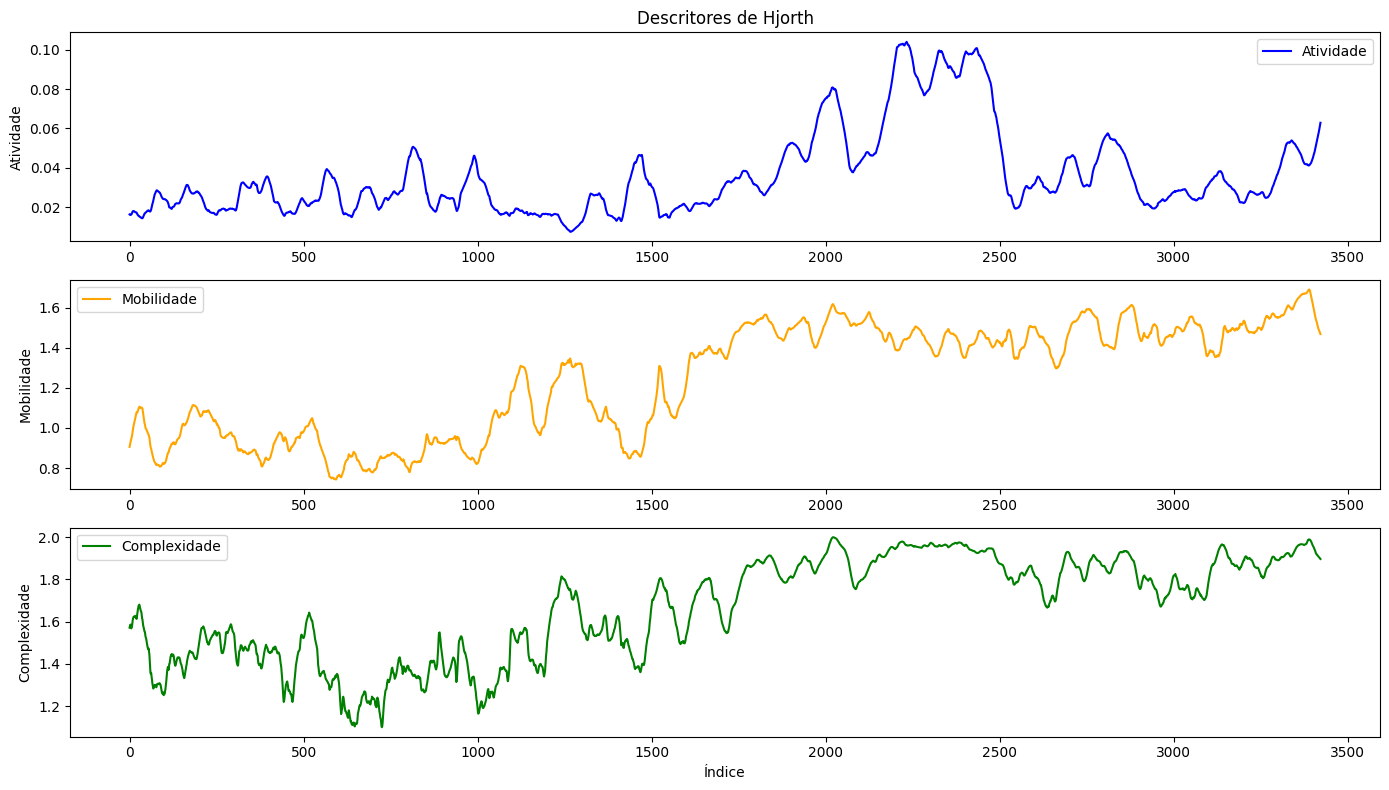

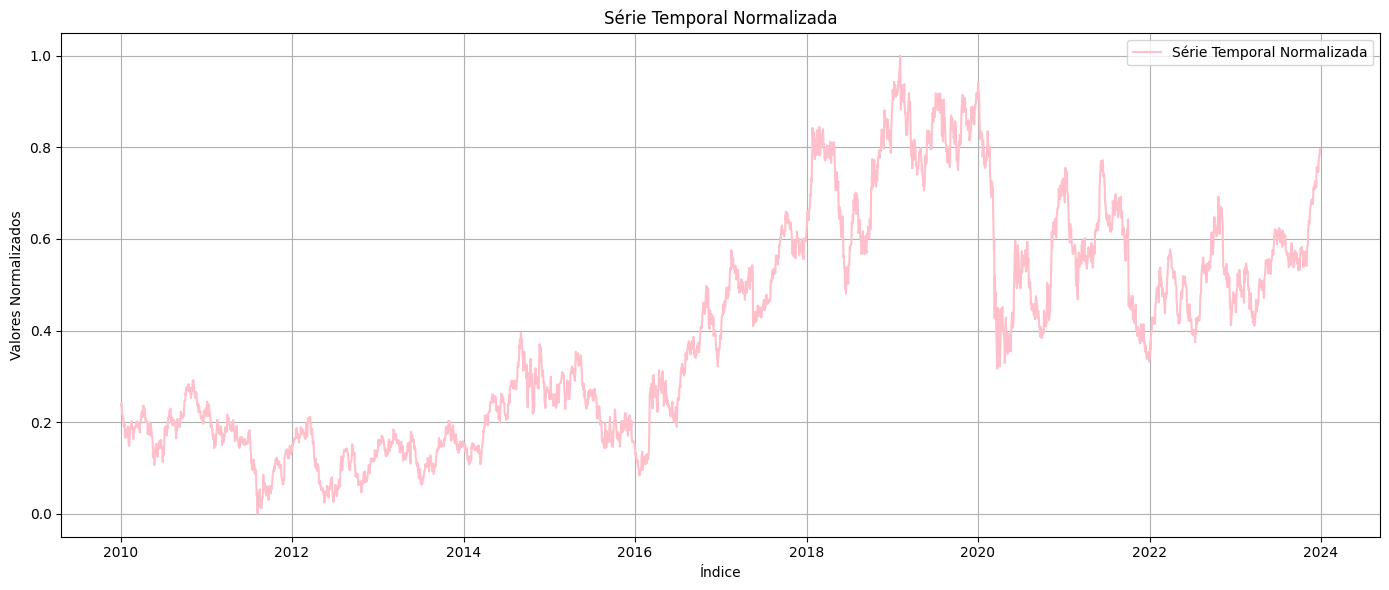

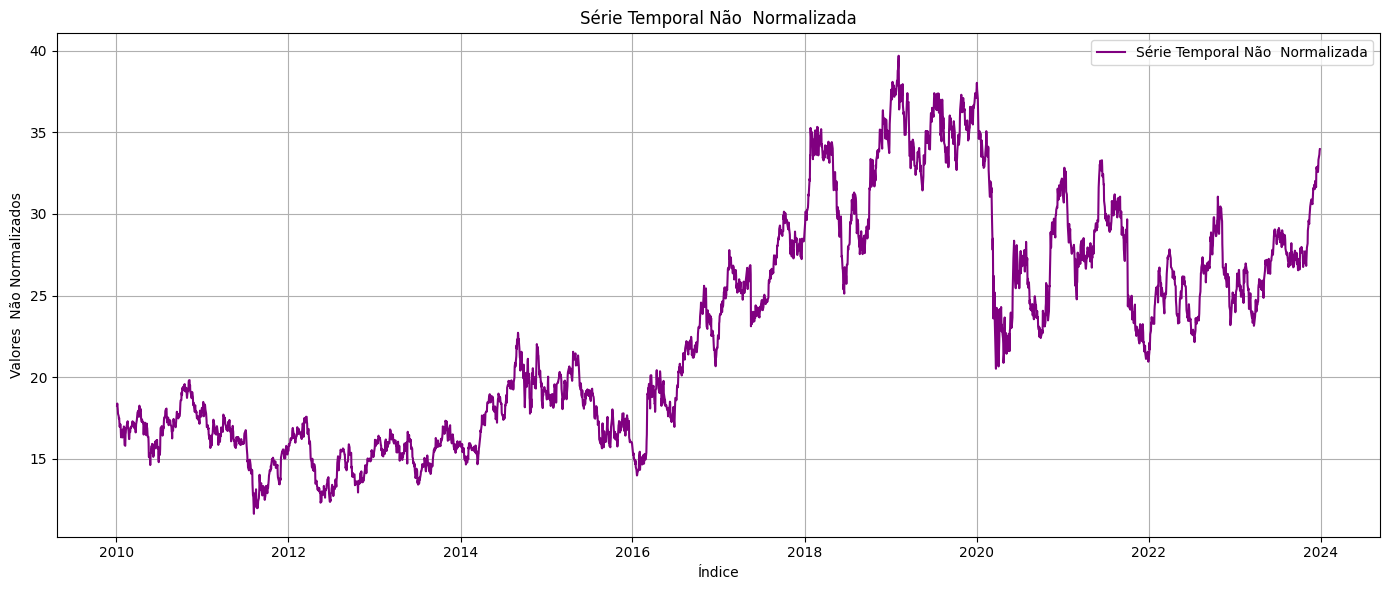

In [ ]:

#dados_normalized
# Função para calcular os descritores de Hjorth
def hjorth_parameters(data):
    # Calcule os descritores de Hjorth para a série temporal
    activity = np.var(data)
    mobility = np.sqrt(np.var(np.diff(data)) / activity)
    complexity = np.sqrt(np.var(np.diff(np.diff(data))) / np.var(np.diff(data)))
    return activity, mobility, complexity

hjorth_activity = []
hjorth_mobility = []
hjorth_complexity = []
window_size = 50
for i in range(len(dados_normalized) - window_size):
    window_data = dados_normalized.iloc[i:i+window_size].values
    activity, mobility, complexity = hjorth_parameters(window_data)
    hjorth_activity.append(activity)
    hjorth_mobility.append(mobility)
    hjorth_complexity.append(complexity)

plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(hjorth_activity, label='Atividade', color='blue')
plt.title('Descritores de Hjorth')
plt.ylabel('Atividade')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(hjorth_mobility, label='Mobilidade', color='orange')
plt.ylabel('Mobilidade')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(hjorth_complexity, label='Complexidade', color='green')
plt.ylabel('Complexidade')
plt.legend()
plt.xlabel('Índice')
plt.tight_layout()
plt.show()

# Plotar a série temporal original normalizada
plt.figure(figsize=(14, 6))
plt.plot(dados_normalized['Close'], label='Série Temporal Normalizada', color='pink')
plt.title('Série Temporal Normalizada')
plt.xlabel('Índice')
plt.ylabel('Valores Normalizados')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(dados['Close'], label='Série Temporal Não  Normalizada', color='purple')
plt.title('Série Temporal Não  Normalizada')
plt.xlabel('Índice')
plt.ylabel('Valores  Não Normalizados')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### *Detecta Changes


Significância Calculada:
23.322352459410926

Percentis dos Valores T2 Calculados:
Percentil 2.5%: 2.298050510242915
Percentil 97.5%: 32.51364548250977

Aviso: O valor de significância pode estar fora dos percentis esperados.


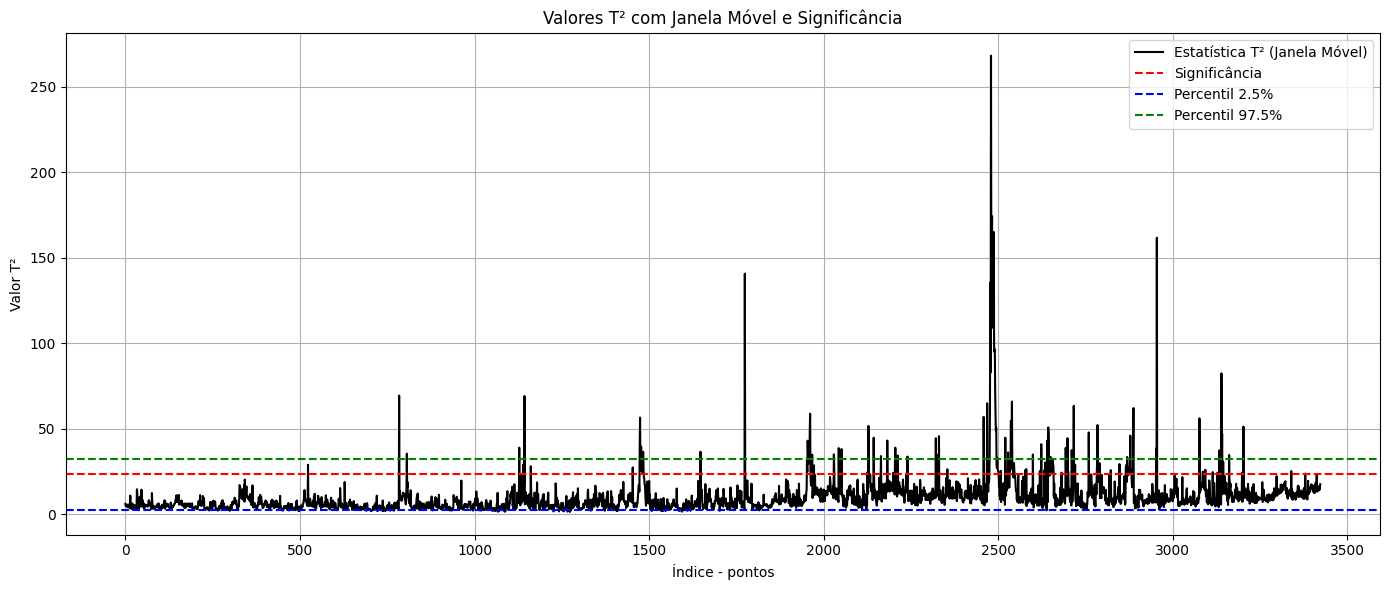

In [ ]:
# Seção 2: Carta Controle

# Função de cálculo da estatística T2 (Fase 4: Modelagem)
def calculate_t2_statistic(dados, mean_vector, inv_covariance_matrix):
    """Calcular a estatística T2 para um vetor de observação."""
    diff_vector = dados - mean_vector
    t_squared = np.dot(np.dot(diff_vector.T, inv_covariance_matrix), diff_vector)
    return t_squared

# Função de cálculo da estatística T2 com janela móvel (Fase 4: Modelagem)
def calculate_moving_t2(dados_normalized, window_size=50):
    """Calcular a estatística T2 com uma janela móvel."""
    t2_statistic_values = []
    for i in range(window_size, len(dados_normalized)):
        current_data = dados_normalized.iloc[i].values
        t_squared = calculate_t2_statistic(current_data, historical_mean_vector, inv_historical_covariance_matrix)
        t2_statistic_values.append(t_squared)
    return t2_statistic_values

historical_mean_vector = dados_normalized.mean().values
historical_covariance_matrix = np.cov(dados_normalized.values.T)
inv_historical_covariance_matrix = np.linalg.inv(historical_covariance_matrix)
alpha=0.01
window_size = 50  # Define o tamanho da janela
moving_t2_statistic_values = calculate_moving_t2(dados_normalized, window_size)

# Função de cálculo da significância (Fase 4: Modelagem)
def calculate_significance(t2_statistic_values, alpha=0.01):
    """Calcular a significância usando a distribuição F."""
    n = len(t2_statistic_values)
    p = len(dados_normalized.columns)
    f_value = f.ppf(1 - alpha, p, n - p)
    significance = (p * (n - 1) / (n - p)) * f_value
    return significance

significance_value = calculate_significance(moving_t2_statistic_values)

print("\nSignificância Calculada:")
print(significance_value)

percentile_025 = np.percentile(moving_t2_statistic_values, 2.5)
percentile_975 = np.percentile(moving_t2_statistic_values, 97.5)

print("\nPercentis dos Valores T2 Calculados:")
print("Percentil 2.5%:", percentile_025)
print("Percentil 97.5%:", percentile_975)

if significance_value < percentile_975:
    print("\nAviso: O valor de significância pode estar fora dos percentis esperados.")
else:
    print("\nO valor de significância está dentro dos percentis esperados.")


# Função de plotar a carta de controle T2 (Fase 4: Modelagem)
def plot_control_chart(moving_t2_statistic_values, significance_value):
    """Plotar a carta de controle T2."""
    plt.figure(figsize=(14, 6))
    plt.plot(moving_t2_statistic_values, color='black', label='Estatística T² (Janela Móvel)')
    plt.axhline(y=significance_value, color='r', linestyle='--', label='Significância')
    plt.axhline(y=np.percentile(moving_t2_statistic_values, 2.5), color='b', linestyle='--', label='Percentil 2.5%')
    plt.axhline(y=np.percentile(moving_t2_statistic_values, 97.5), color='g', linestyle='--', label='Percentil 97.5%')
    plt.title('Valores T² com Janela Móvel e Significância')
    plt.xlabel('Índice - pontos')
    plt.ylabel('Valor T²')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Plotar o gráfico se a lista de valores T2 não estiver vazia
if moving_t2_statistic_values:
    plot_control_chart(moving_t2_statistic_values, significance_value)



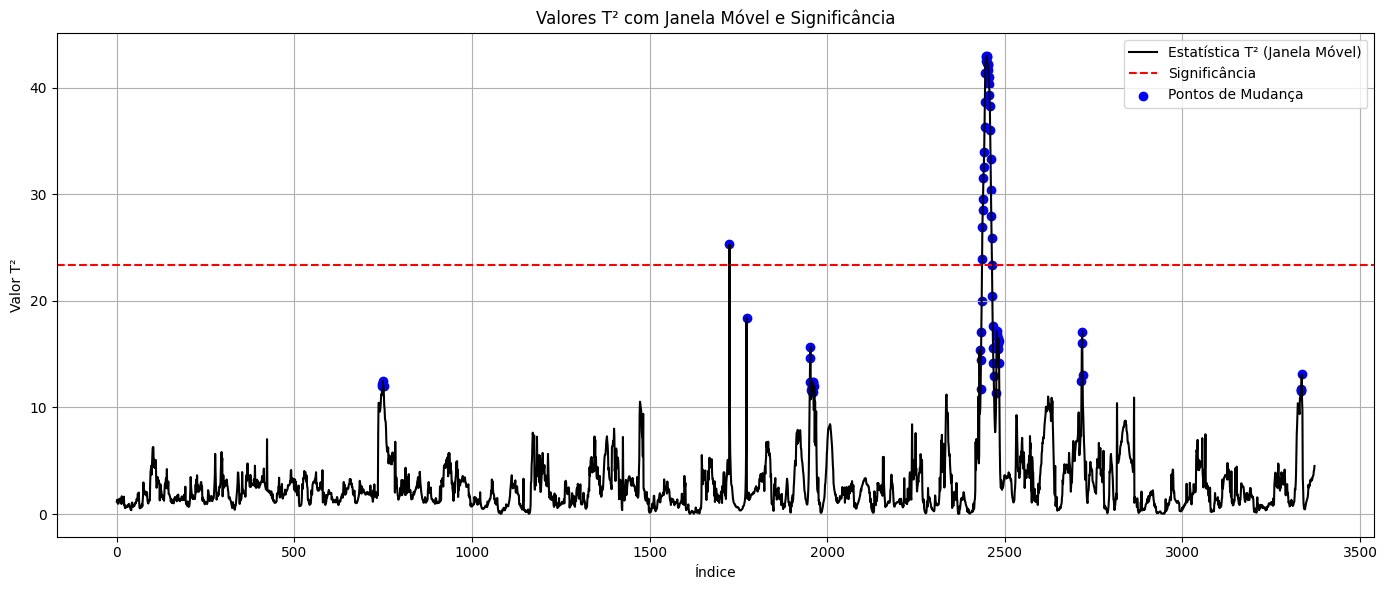

In [ ]:

# Plotar a carta de controle T2 com pontos de mudança
plt.figure(figsize=(14, 6))
plt.plot(t2_statistic_values, color='black', label='Estatística T² (Janela Móvel)')
plt.axhline(y=significance_value, color='r', linestyle='--', label='Significância')
plt.scatter(changes, [t2_statistic_values[i] for i in changes], color='blue', label='Pontos de Mudança')
plt.title('Valores T² com Janela Móvel e Significância')
plt.xlabel('Índice')
plt.ylabel('Valor T²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



####*Identifica pontos de mudança (gráfico linhas)

[*********************100%%**********************]  1 of 1 completed


Análise das Mudanças em Relação aos Novos Regimes:
 Novo Regime Início  Mudança Detectada  Atraso na Detecção  Início da Evidência  Atraso da Evidência
               1630               1725                  95                 1630                   95
               1985               2429                 444                 2001                  428
               2525               2716                 191                 2525                  191

Quantidade total de linhas: 3


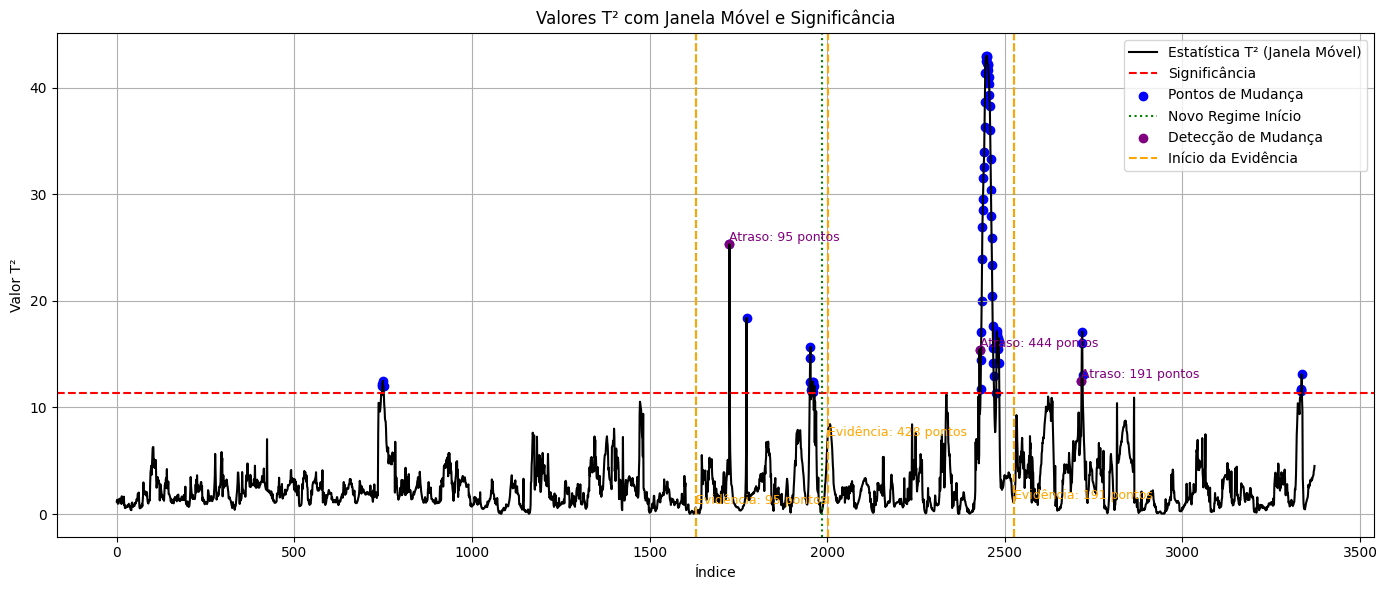

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f
import yfinance as yf
import ruptures as rpt

# Função para baixar dados de ações do Yahoo Finance
def download_stock_data(ticker, start_date, end_date):
    dados = yf.download(ticker, start_date, end_date)
    return dados

# Função para calcular descritores de Hjorth
def hjorth_activity(data):
    diff = np.diff(data)
    diff_diff = np.diff(diff)
    var_activity = np.var(data)
    var_diff = np.var(diff)
    var_diff_diff = np.var(diff_diff)
    activity = np.sqrt(var_activity)
    mobility = np.sqrt(var_diff / var_activity) if var_activity != 0 else np.nan
    complexity = np.sqrt(var_diff_diff / var_diff) if var_diff != 0 else np.nan
    return activity, mobility, complexity

# Função de cálculo da estatística T2
def calculate_t2_statistic(data, mean_vector, inv_covariance_matrix):
    diff_vector = data - mean_vector
    t_squared = np.dot(np.dot(diff_vector.T, inv_covariance_matrix), diff_vector)
    return t_squared

# Função de cálculo da estatística T2 com janela móvel
def calculate_moving_t2(data_normalized, mean_vector, inv_covariance_matrix, window_size=50):
    t2_statistic_values = []
    for i in range(window_size, len(data_normalized)):
        window_data = data_normalized.iloc[i].values
        t_squared = calculate_t2_statistic(window_data, mean_vector, inv_covariance_matrix)
        t2_statistic_values.append(t_squared)
    return t2_statistic_values

# Função para calcular a significância
def calculate_significance(t2_statistic_values, p, alpha=0.01):
    n = len(t2_statistic_values)
    f_value = f.ppf(1 - alpha, p, n - p)
    significance = (p * (n - 1) / (n - p)) * f_value
    return significance

# Função para detectar mudanças
def detect_changes(t2_statistic_values, significance_value):
    changes = []
    for i, t2 in enumerate(t2_statistic_values):
        if t2 > significance_value:
            changes.append(i)
    return changes

# Função para analisar mudanças detectadas em relação a novos regimes
def analyze_changes(changes, new_regime_starts, t2_statistic_values):
    detections = []
    for new_regime_start in new_regime_starts:
        for change in changes:
            if change >= new_regime_start:
                detection_lag = change - new_regime_start

                # Identificar início da evidência da mudança
                start_evidence = new_regime_start
                for j in range(new_regime_start, change):
                    if t2_statistic_values[j] > np.mean(t2_statistic_values[:new_regime_start]) + 2 * np.std(t2_statistic_values[:new_regime_start]):
                        start_evidence = j
                        break
                evidence_lag = change - start_evidence

                detections.append((new_regime_start, change, detection_lag, start_evidence, evidence_lag))
                break  # Continue para o próximo novo regime após detectar a primeira mudança
    return detections

# Função para detectar novos regimes (changepoints) usando ruptures
def detect_new_regimes(data, model="l2", penalty=10):
    algo = rpt.Pelt(model=model).fit(data)
    result = algo.predict(pen=penalty)
    return result[:-1]  # Remover o último ponto, que é o fim da série

# Baixar dados
dados = download_stock_data('ITUB4.SA', '2010-01-01', '2024-01-01')

# Normalizar dados
dados_normalized = (dados - dados.min()) / (dados.max() - dados.min())

# Calcular descritores de Hjorth para janelas móveis
window_size = 50
hjorth_data = []
for i in range(window_size, len(dados_normalized)):
    window_data = dados_normalized['Close'].values[i-window_size:i]
    activity, mobility, complexity = hjorth_activity(window_data)
    hjorth_data.append([activity, mobility, complexity])

hjorth_df = pd.DataFrame(hjorth_data, columns=['Activity', 'Mobility', 'Complexity'])

# Calcular a média e a matriz de covariância dos descritores de Hjorth
mean_vector = hjorth_df.mean().values
covariance_matrix = np.cov(hjorth_df.T)
inv_covariance_matrix = np.linalg.inv(covariance_matrix)

# Calcular a estatística T2 com janela móvel
t2_statistic_values = calculate_moving_t2(hjorth_df, mean_vector, inv_covariance_matrix, window_size)

# Calcular a significância
alpha = 0.01
p = hjorth_df.shape[1]  # número de variáveis (descritores de Hjorth)
significance_value = calculate_significance(t2_statistic_values, p, alpha)

# Detectar mudanças
changes = detect_changes(t2_statistic_values, significance_value)

# Detectar novos regimes
new_regime_starts = detect_new_regimes(dados_normalized['Close'].values.reshape(-1, 1))

# Analisar mudanças detectadas em relação a novos regimes
detections = analyze_changes(changes, new_regime_starts, t2_statistic_values)

# Criar tabela com a análise das mudanças
detection_df = pd.DataFrame(detections, columns=['Novo Regime Início', 'Mudança Detectada', 'Atraso na Detecção', 'Início da Evidência', 'Atraso da Evidência'])

# Imprimir a tabela completa com a análise das mudanças e a quantidade total de linhas
print("Análise das Mudanças em Relação aos Novos Regimes:")
print(detection_df.to_string(index=False))
print(f"\nQuantidade total de linhas: {len(detection_df)}")

# Plotar a carta de controle T2 com pontos de mudança, pontos de novo regime e atrasos na detecção
plt.figure(figsize=(14, 6))
plt.plot(t2_statistic_values, color='black', label='Estatística T² (Janela Móvel)')
plt.axhline(y=significance_value, color='r', linestyle='--', label='Significância')

# Sinalizar os pontos de mudança
plt.scatter(changes, [t2_statistic_values[i] for i in changes], color='blue', label='Pontos de Mudança')

# Sinalizar os pontos de novo regime e atrasos na detecção
for start, change, lag, start_evidence, evidence_lag in detections:
    plt.axvline(x=start, color='green', linestyle=':', label='Novo Regime Início' if start == new_regime_starts[0] else "")
    plt.scatter(change, t2_statistic_values[change], color='purple', label='Detecção de Mudança' if change == detections[0][1] else "")
    plt.text(change, t2_statistic_values[change], f'Atraso: {lag} pontos', color='purple', fontsize=9, verticalalignment='bottom')
    plt.axvline(x=start_evidence, color='orange', linestyle='--', label='Início da Evidência' if start_evidence == detections[0][3] else "")
    plt.text(start_evidence, t2_statistic_values[start_evidence], f'Evidência: {evidence_lag} pontos', color='orange', fontsize=9, verticalalignment='bottom')

plt.title('Valores T² com Janela Móvel e Significância')
plt.xlabel('Índice')
plt.ylabel('Valor T²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


####  Validação- Carta Controle

In [ ]:


# Validação Cruzada
def cross_validate_t2(dados_normalized, window_sizes, alphas):
    tscv = TimeSeriesSplit(n_splits=5)
    best_params = {}
    best_score = float('inf')

    for train_index, test_index in tscv.split(dados_normalized):
        train_data, test_data = dados_normalized.iloc[train_index], dados_normalized.iloc[test_index]
        historical_mean_vector = train_data.mean().values
        historical_covariance_matrix = np.cov(train_data.values.T)
        inv_historical_covariance_matrix = np.linalg.inv(historical_covariance_matrix)

        for window_size in window_sizes:
            for alpha in alphas:
                t2_statistic_values = calculate_moving_t2(train_data, historical_mean_vector, inv_historical_covariance_matrix, window_size)
                significance_value = calculate_significance(t2_statistic_values, alpha)
                test_t2_statistic_values = calculate_moving_t2(test_data, historical_mean_vector, inv_historical_covariance_matrix, window_size)

                percentile_975 = np.percentile(test_t2_statistic_values, 97.5)
                score = abs(significance_value - percentile_975)

                if score < best_score:
                    best_score = score
                    best_params = {'window_size': window_size, 'alpha': alpha}

    return best_params

# Exemplo de uso da validação cruzada
window_sizes = [20, 30, 40, 50]
alphas = [0.01, 0.05, 0.1]
best_params = cross_validate_t2(dados_normalized, window_sizes, alphas)

print("\nMelhores Parâmetros Encontrados:")
print(best_params)



Melhores Parâmetros Encontrados:
{'window_size': 50, 'alpha': 0.1}


[*********************100%%**********************]  1 of 1 completed


                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2010-01-04 -0.767352 -0.694745 -0.731586 -0.684603  -0.980820 -0.881843
2010-01-05 -0.677839 -0.702071 -0.662837 -0.667088  -0.971786 -1.113162
2010-01-06 -0.675820 -0.694745 -0.676451 -0.690666  -0.983948 -0.970157
2010-01-07 -0.709472 -0.724051 -0.686661 -0.718286  -0.998194 -1.015423
2010-01-08 -0.707453 -0.742034 -0.729544 -0.758705  -1.019045 -1.030929


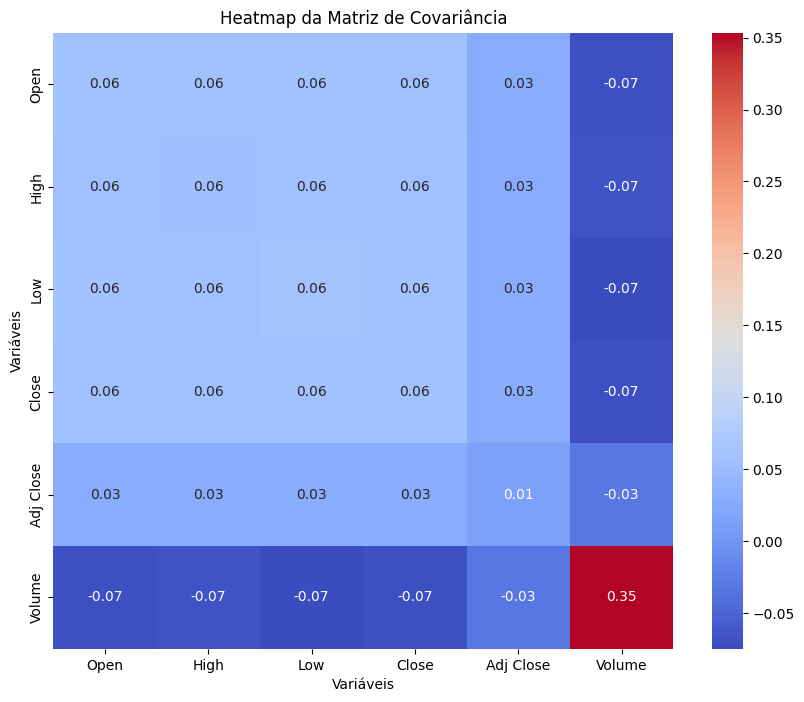

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

def download_stock_data(ticker, start_date, end_date):
    """Baixar dados de ações do Yahoo Finance."""
    dados = yf.download(ticker, start_date, end_date)
    return dados

# Passo 1: Baixar dados
dados = download_stock_data('ITUB4.SA', '2010-01-01', '2024-01-01')


# Carregar e normalizar os dados
#dados = pd.read_csv('seus_dados.csv')  # Substitua pelo seu arquivo de dados
dados_normalized = (dados - dados.mean()) / dados.std()  # Normalizar os dados

# Exibir as primeiras linhas dos dados normalizados
print(dados_normalized.head())

# Dividindo os dados em treino e teste usando TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(dados_normalized):
    train_data, test_data = dados_normalized.iloc[train_index], dados_normalized.iloc[test_index]
    historical_mean_vector = train_data.mean().values
    historical_covariance_matrix = np.cov(train_data.values.T)
    inv_historical_covariance_matrix = np.linalg.inv(historical_covariance_matrix)

    # Plotar a matriz de covariância como um heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(historical_covariance_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=dados_normalized.columns, yticklabels=dados_normalized.columns)
    plt.title('Heatmap da Matriz de Covariância')
    plt.xlabel('Variáveis')
    plt.ylabel('Variáveis')
    plt.show()

    # Apenas plote uma vez para visualização, removendo o break se quiser plotar em todos os splits
    break


            20_day_median  activity  mobility  complexity      Open      High  \
Date                                                                            
2010-02-02      -0.871587 -0.058120 -1.254113    1.028998 -0.879185 -0.886720   
2010-02-03      -0.879384 -0.175385 -1.101452    0.652022 -0.875150 -0.892710   
2010-02-04      -0.884808 -0.353231 -0.892872    0.864379 -0.918861 -0.937964   
2010-02-05      -0.897690 -0.463503 -0.464664    0.233324 -1.010991 -0.993201   
2010-02-08      -0.908877 -0.482760 -0.373545    0.086779 -1.040580 -1.050435   

                 Low     Close  Adj Close    Volume  
Date                                                 
2010-02-02 -0.876674 -0.878751  -1.085398 -1.017599  
2010-02-03 -0.884155 -0.889521  -1.090961 -1.175599  
2010-02-04 -0.980735 -0.985776  -1.140672 -0.904145  
2010-02-05 -1.081395 -1.047029  -1.172307 -0.322066  
2010-02-08 -1.039907 -1.053760  -1.175782 -0.900349  


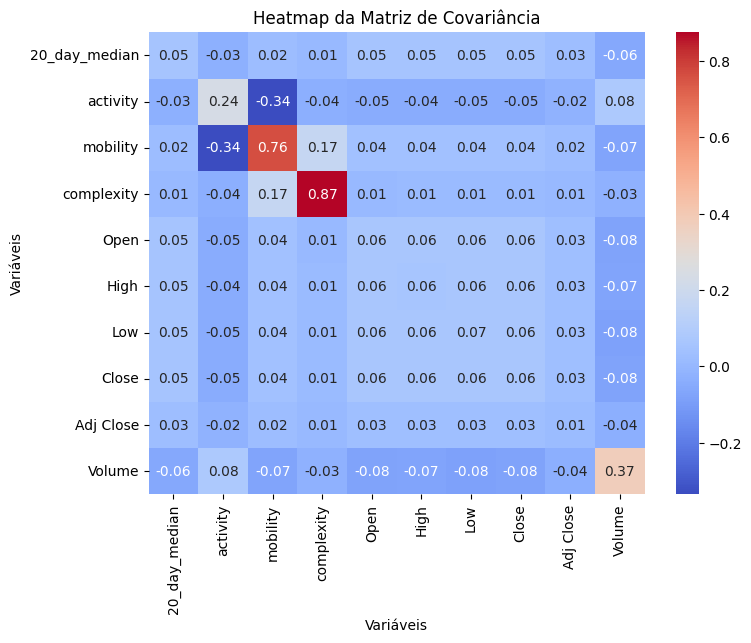

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit



# Passo 1: Baixar dados
#dados = download_stock_data('ITUB4.SA', '2010-01-01', '2024-01-01')
dados = dados_all

# Carregar e normalizar os dados
#dados = pd.read_csv('seus_dados.csv')  # Substitua pelo seu arquivo de dados
dados_normalized = (dados - dados.mean()) / dados.std()  # Normalizar os dados

# Exibir as primeiras linhas dos dados normalizados
print(dados_normalized.head())

# Dividindo os dados em treino e teste usando TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(dados_normalized):
    train_data, test_data = dados_normalized.iloc[train_index], dados_normalized.iloc[test_index]
    historical_mean_vector = train_data.mean().values
    historical_covariance_matrix = np.cov(train_data.values.T)
    inv_historical_covariance_matrix = np.linalg.inv(historical_covariance_matrix)

    # Plotar a matriz de covariância como um heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(historical_covariance_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=dados_normalized.columns, yticklabels=dados_normalized.columns)
    plt.title('Heatmap da Matriz de Covariância')
    plt.xlabel('Variáveis')
    plt.ylabel('Variáveis')
    plt.show()

    # Apenas plote uma vez para visualização, removendo o break se quiser plotar em todos os splits
    break


#### *Intervalo

[*********************100%%**********************]  1 of 1 completed


Análise das Mudanças em Relação aos Novos Regimes:
 Novo Regime Início  Mudança Detectada  Atraso na Detecção  Início da Evidência  Atraso da Evidência
               1630               1725                  95                 1630                   95
               1985               2429                 444                 2001                  428
               2525               2716                 191                 2525                  191

Quantidade total de linhas: 3


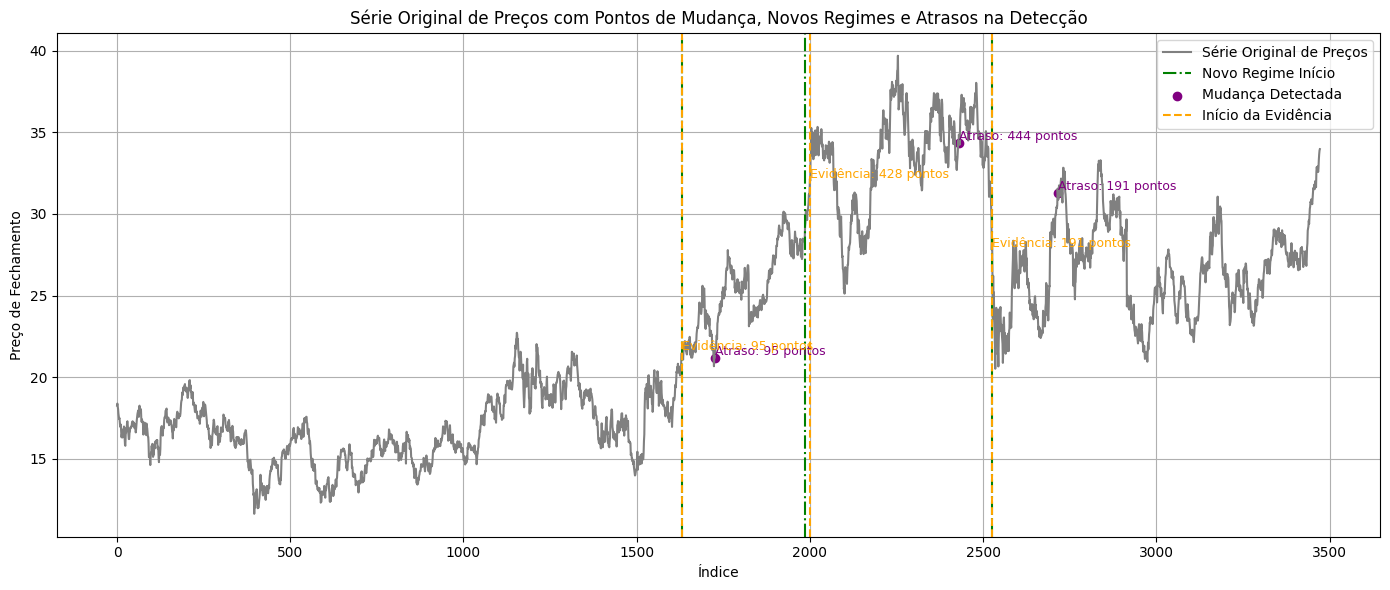

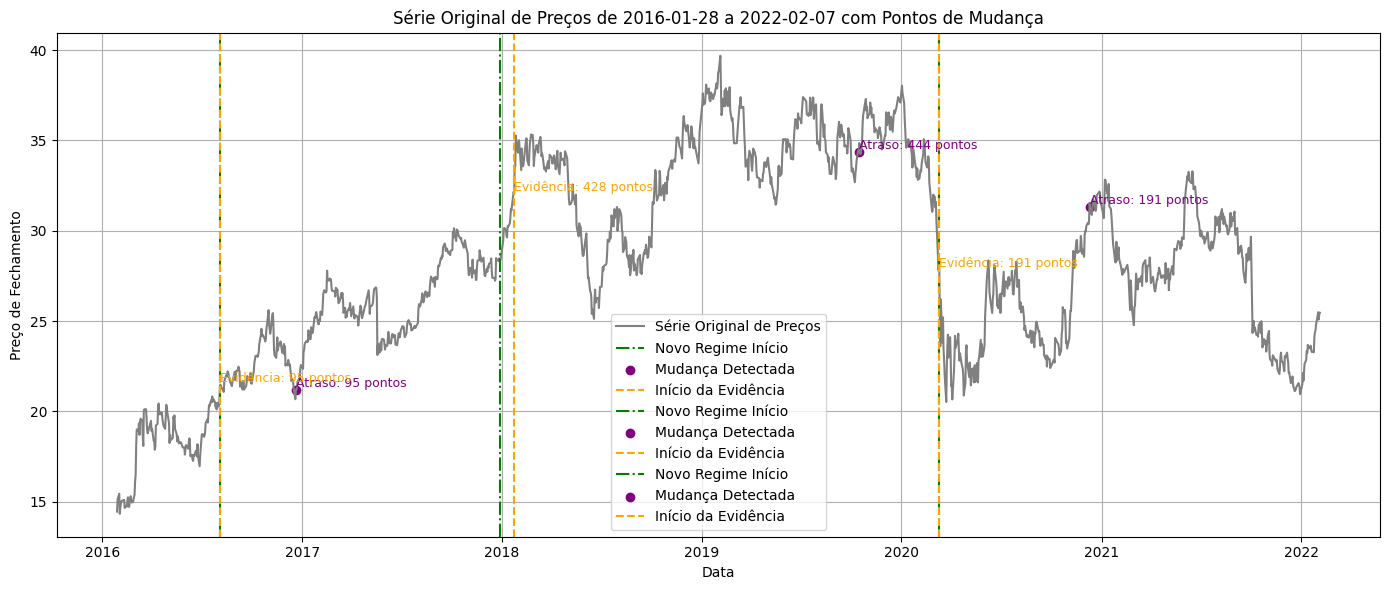

In [ ]:

# Função para baixar dados de ações do Yahoo Finance
def download_stock_data(ticker, start_date, end_date):
    dados = yf.download(ticker, start_date, end_date)
    return dados

# Função para calcular descritores de Hjorth
def hjorth_activity(data):
    diff = np.diff(data)
    diff_diff = np.diff(diff)
    var_activity = np.var(data)
    var_diff = np.var(diff)
    var_diff_diff = np.var(diff_diff)
    activity = np.sqrt(var_activity)
    mobility = np.sqrt(var_diff / var_activity) if var_activity != 0 else np.nan
    complexity = np.sqrt(var_diff_diff / var_diff) if var_diff != 0 else np.nan
    return activity, mobility, complexity

# Função de cálculo da estatística T2
def calculate_t2_statistic(data, mean_vector, inv_covariance_matrix):
    diff_vector = data - mean_vector
    t_squared = np.dot(np.dot(diff_vector.T, inv_covariance_matrix), diff_vector)
    return t_squared

# Função de cálculo da estatística T2 com janela móvel
def calculate_moving_t2(data_normalized, mean_vector, inv_covariance_matrix, window_size=50):
    t2_statistic_values = []
    for i in range(window_size, len(data_normalized)):
        window_data = data_normalized.iloc[i].values
        t_squared = calculate_t2_statistic(window_data, mean_vector, inv_covariance_matrix)
        t2_statistic_values.append(t_squared)
    return t2_statistic_values

# Função para calcular a significância
def calculate_significance(t2_statistic_values, p, alpha=0.01):
    n = len(t2_statistic_values)
    f_value = f.ppf(1 - alpha, p, n - p)
    significance = (p * (n - 1) / (n - p)) * f_value
    return significance

# Função para detectar mudanças
def detect_changes(t2_statistic_values, significance_value):
    changes = []
    for i, t2 in enumerate(t2_statistic_values):
        if t2 > significance_value:
            changes.append(i)
    return changes

# Função para analisar mudanças detectadas em relação a novos regimes
def analyze_changes(changes, new_regime_starts, t2_statistic_values):
    detections = []
    for new_regime_start in new_regime_starts:
        for change in changes:
            if change >= new_regime_start:
                detection_lag = change - new_regime_start

                # Identificar início da evidência da mudança
                start_evidence = new_regime_start
                for j in range(new_regime_start, change):
                    if t2_statistic_values[j] > np.mean(t2_statistic_values[:new_regime_start]) + 2 * np.std(t2_statistic_values[:new_regime_start]):
                        start_evidence = j
                        break
                evidence_lag = change - start_evidence

                detections.append((new_regime_start, change, detection_lag, start_evidence, evidence_lag))
                break  # Continue para o próximo novo regime após detectar a primeira mudança
    return detections

# Função para detectar novos regimes (changepoints) usando ruptures
def detect_new_regimes(data, model="l2", penalty=10):
    algo = rpt.Pelt(model=model).fit(data)
    result = algo.predict(pen=penalty)
    return result[:-1]  # Remover o último ponto, que é o fim da série

# Baixar dados
dados = download_stock_data('ITUB4.SA', '2010-01-01', '2024-01-01')

# Normalizar dados
dados_normalized = (dados - dados.min()) / (dados.max() - dados.min())

# Calcular descritores de Hjorth para janelas móveis
window_size = 50
hjorth_data = []
for i in range(window_size, len(dados_normalized)):
    window_data = dados_normalized['Close'].values[i-window_size:i]
    activity, mobility, complexity = hjorth_activity(window_data)
    hjorth_data.append([activity, mobility, complexity])

hjorth_df = pd.DataFrame(hjorth_data, columns=['Activity', 'Mobility', 'Complexity'])

# Calcular a média e a matriz de covariância dos descritores de Hjorth
mean_vector = hjorth_df.mean().values
covariance_matrix = np.cov(hjorth_df.T)
inv_covariance_matrix = np.linalg.inv(covariance_matrix)

# Calcular a estatística T2 com janela móvel
t2_statistic_values = calculate_moving_t2(hjorth_df, mean_vector, inv_covariance_matrix, window_size)

# Calcular a significância
alpha = 0.01
p = hjorth_df.shape[1]  # número de variáveis (descritores de Hjorth)
significance_value = calculate_significance(t2_statistic_values, p, alpha)

# Detectar mudanças
changes = detect_changes(t2_statistic_values, significance_value)

# Detectar novos regimes
new_regime_starts = detect_new_regimes(dados_normalized['Close'].values.reshape(-1, 1))

# Analisar mudanças detectadas em relação a novos regimes
detections = analyze_changes(changes, new_regime_starts, t2_statistic_values)

# Criar tabela com a análise das mudanças
detection_df = pd.DataFrame(detections, columns=['Novo Regime Início', 'Mudança Detectada', 'Atraso na Detecção', 'Início da Evidência', 'Atraso da Evidência'])

# Imprimir a tabela completa com a análise das mudanças e a quantidade total de linhas
print("Análise das Mudanças em Relação aos Novos Regimes:")
print(detection_df.to_string(index=False))
print(f"\nQuantidade total de linhas: {len(detection_df)}")

# Plotar a série original de preços com os pontos de mudança, novos regimes e atrasos na detecção
plt.figure(figsize=(14, 6))
plt.plot(dados['Close'].values, color='gray', label='Série Original de Preços')
plt.title('Série Original de Preços com Pontos de Mudança, Novos Regimes e Atrasos na Detecção')
plt.xlabel('Índice')
plt.ylabel('Preço de Fechamento')

# Sinalizar os pontos de mudança, novos regimes e atrasos na detecção
for start, change, lag, start_evidence, evidence_lag in detections:
    plt.axvline(x=start, color='green', linestyle='-.', label='Novo Regime Início' if start == new_regime_starts[0] else "")
    plt.scatter(change, dados['Close'].values[change], color='purple', label='Mudança Detectada' if change == detections[0][1] else "")
    plt.text(change, dados['Close'].values[change], f'Atraso: {lag} pontos', color='purple', fontsize=
                 9, verticalalignment='bottom')
    plt.axvline(x=start_evidence, color='orange', linestyle='--', label='Início da Evidência' if start_evidence == detections[0][3] else "")
    plt.text(start_evidence, dados['Close'].values[start_evidence], f'Evidência: {evidence_lag} pontos', color='orange', fontsize=9, verticalalignment='bottom')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotar uma parte específica da série de dados
start_idx = 1500
end_idx = 3000
start_date = dados.index[start_idx]
end_date = dados.index[end_idx]

plt.figure(figsize=(14, 6))
plt.plot(dados.index[start_idx:end_idx], dados['Close'].values[start_idx:end_idx], color='gray', label='Série Original de Preços')
plt.title(f'Série Original de Preços de {start_date.date()} a {end_date.date()} com Pontos de Mudança')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')

# Sinalizar os pontos de mudança, novos regimes e atrasos na detecção
for start, change, lag, start_evidence, evidence_lag in detections:
    if start_idx <= start <= end_idx or start_idx <= change <= end_idx or start_idx <= start_evidence <= end_idx:
        if start_idx <= start <= end_idx:
            plt.axvline(x=dados.index[start], color='green', linestyle='-.', label='Novo Regime Início')
        if start_idx <= change <= end_idx:
            plt.scatter(dados.index[change], dados['Close'].values[change], color='purple', label='Mudança Detectada')
            plt.text(dados.index[change], dados['Close'].values[change], f'Atraso: {lag} pontos', color='purple', fontsize=9, verticalalignment='bottom')
        if start_idx <= start_evidence <= end_idx:
            plt.axvline(x=dados.index[start_evidence], color='orange', linestyle='--', label='Início da Evidência')
            plt.text(dados.index[start_evidence], dados['Close'].values[start_evidence], f'Evidência: {evidence_lag} pontos', color='orange', fontsize=9, verticalalignment='bottom')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
print(dados.head(2))

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2010-01-04  17.708261  18.436810  17.708261  18.268333  10.141708  11843397
2010-01-05  18.313868  18.386723  18.168158  18.386723  10.207426   8593315


In [ ]:
print(dados_normalized.columns)
print(dados_normalized.head(2))

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA_20',
       'SMA_50', 'Volatility', 'Date'],
      dtype='object')
                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2010-03-17  0.203484  0.191673  0.202764  0.193946   0.109844  0.048246   
2010-03-18  0.196685  0.183461  0.196174  0.189077   0.106921  0.067536   

              SMA_20    SMA_50  Volatility       Date  
Date                                                   
2010-03-17  0.174234  0.166637    0.050266 2010-03-17  
2010-03-18  0.173517  0.165541    0.046727 2010-03-18  
